In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn import metrics

import json
import os
import pandas as pd

from util import gen_model_preds_df, report_metrics

with open('SWDA_dialogue-acts.json') as f:
    swda_tags = json.load(f, strict=False)
swda_tags_list = list(swda_tags)
with open('AMI-DA_dialogue-acts.json') as f:
    ami_tags = json.load(f, strict=False)
ami_tags_list = list(ami_tags)

models = ['bert', 'bert_random-init', 'bert_frozen']

model_dirs = [f'../../models/SWDA-L_{model}_2019-11-20/' for model in models]
dfs = gen_model_preds_df('SWDA', models, model_dirs)

model_dirs = [f'../../models/AMI-DA-L_{model}_2019-11-20/' for model in models]
dfa = gen_model_preds_df('AMI-DA', models, model_dirs)
dfa = dfa[dfa['da_tag'].notnull()]

# Comparing performance

How much does pre-training vs. fine-tuning contribute to model accuracy? 

We compare the DAR performance of standard Devlid, et al. (2018) pre-trained BERT (`bert`) as an utterance encoder to the same encoder architecture with no pre-training (`bert_random-init`),
We also compare the fine-tuned model (`bert`) to BERT with pre-training, but no fine-tuning (`bert_frozen`).

* `bert` -- BERT with pre-training and fine-tuning
* `bert_frozen` -- BERT with pre-training but no fine-tuning
* `bert_random-init` -- BERT with no pre training but with "fine-tunining"

In [2]:
report_metrics([dfs,dfa], models)

/Users/xnobwi/.virtualenvs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SWBD       AMI
bert             macro precision  0.561119  0.587054
                 macro recall     0.430470  0.483137
                 macro f1         0.459891  0.500326
                 micro accuracy   0.769267  0.669527
bert_random-init macro precision  0.388113  0.397243
                 macro recall     0.313539  0.341935
                 macro f1         0.321834  0.334531
                 micro accuracy   0.738038  0.615486
bert_frozen      macro precision  0.120535  0.150745
                 macro recall     0.083235  0.173323
                 macro f1         0.077471  0.144419
                 micro accuracy   0.556122  0.466002

# Further analysis

## Impact of pre-training

First, we consider the impact of pre-training. The pre-trained model gives a modest performance boost (%3) over the  model with no-fine tuning.
The following figure shows how each dialogue act contributes to the increase in the accuracy of the model.
Namely, we look at dialogue acts that `bert` gets right and `bert_random-init` gets wrong, and normalize for ground-truth dialogue act frequency.

Pre-trained bert performs better than the randomly-initialized model by about 3 percentage points, suggesting that the information learning in pre-training is at least somewhat useful in DAR.
However, the difference in accuracy between the pre-trained model that was fine-tuned (`bert`) and the one that was not (`bert_frozen`) is much larger.
This suggests that the representations learned in BERT's pre-training fail to encode information important to dialogue act recoginition.
In the following analysis we consider two questions raised by these results:

1. How does BERT's standard pre-training help in DAR? I.e., how does `bert` improve over `bert_random-init`?
2. How are the representations learned in BERT's standard pre-traninig lacking for DAR? I.e, how does `bert` improve over `bert_frozen`.

To answer these questions, we consider diffences in performance between the models, segmented by dialogue act.

/Users/xnobwi/.virtualenvs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1511: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


F1 score


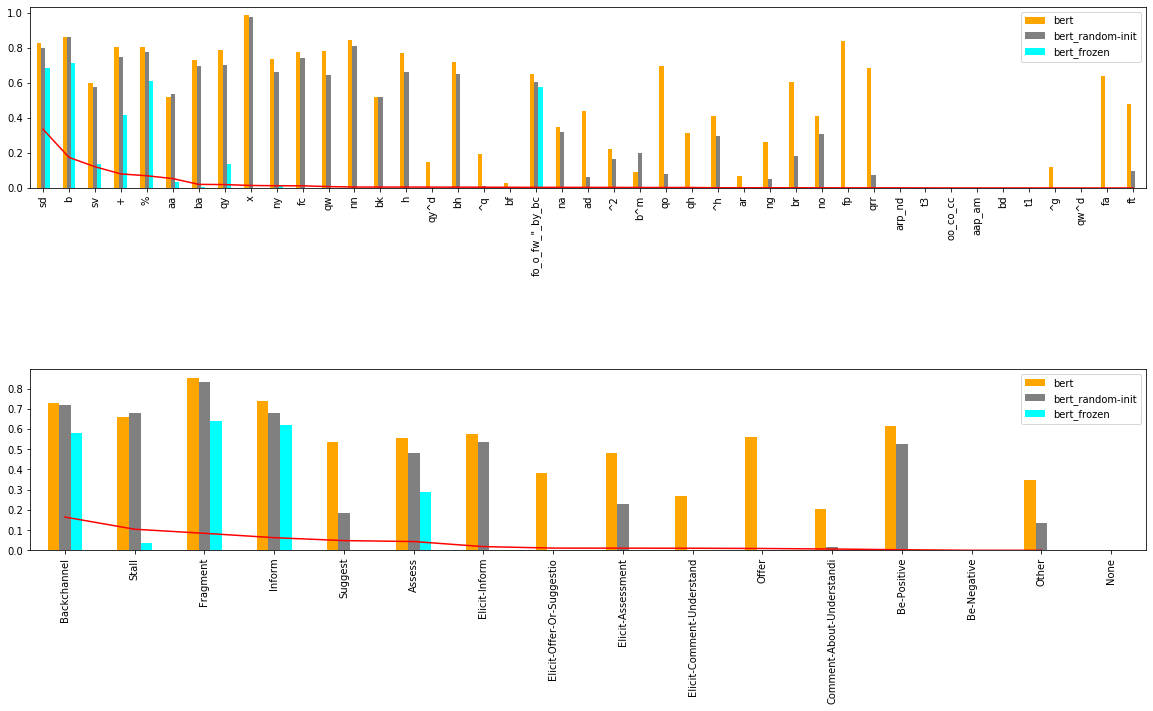

In [3]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
plt.subplots_adjust(hspace = 1)
swda_tags_display = {t:swda_tags[t][:25] for t in swda_tags}
ami_tags_display = {t:ami_tags[t][:25] for t in ami_tags}

res_s = pd.DataFrame([
    metrics.f1_score(dfs['da_tag'], dfs[model], swda_tags_list, average=None)
    for model in models],
    index=models, columns=swda_tags_list)
(dfs['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[0])
plot = res_s.T.plot(kind='bar', ax=axes[0], color=['orange', 'gray', 'cyan'])

res_a = pd.DataFrame([metrics.f1_score(dfa['da_tag'], dfa[model], ami_tags_list, average=None) 
              for model in models]
    , index=models, columns=ami_tags_list)
(dfa['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[1])
plot = res_a.rename(ami_tags_display, axis=1).rename(swda_tags_display, axis=1).T.plot(kind='bar', ax=axes[1], color=['orange', 'gray', 'cyan'])

print("F1 score")

In [4]:
questions_s = ['qy', 'qw', 'qy^d', 'bh', 'qo', 'qh', '^g', 'qw^d']
print(res_s[questions_s].mean(axis=1))
print(res_s[[t for t in swda_tags_list if not t in questions_s]].mean(axis=1))

bert                0.446829
bert_random-init    0.259911
bert_frozen         0.017233
dtype: float64
bert                0.462877
bert_random-init    0.335988
bert_frozen         0.091239
dtype: float64


Precision


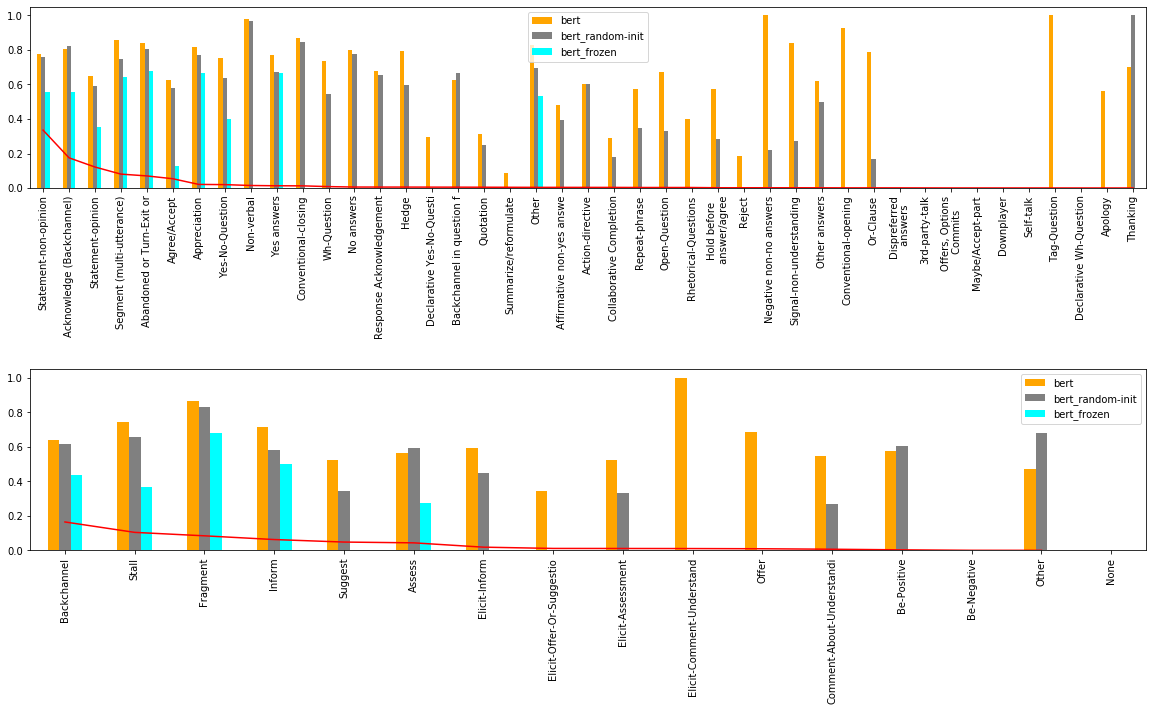

In [5]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
plt.subplots_adjust(hspace = 1)
swda_tags_display = {t:swda_tags[t][:25] for t in swda_tags}
ami_tags_display = {t:ami_tags[t][:25] for t in ami_tags}

res = pd.DataFrame([
    metrics.precision_score(dfs['da_tag'], dfs[model], swda_tags_list, average=None)
    for model in models],
    index=models, columns=swda_tags_list).rename(swda_tags_display, axis=1)
(dfs['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[0])
plot = res.T.plot(kind='bar', ax=axes[0], color=['orange', 'gray', 'cyan'])

res = pd.DataFrame([metrics.precision_score(dfa['da_tag'], dfa[model], ami_tags_list, average=None) 
              for model in models]
    , index=models, columns=ami_tags_list).rename(ami_tags_display, axis=1)
(dfa['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[1])
plot = res.T.plot(kind='bar', ax=axes[1], color=['orange', 'gray', 'cyan'])

print("Precision")

/Users/xnobwi/.virtualenvs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall


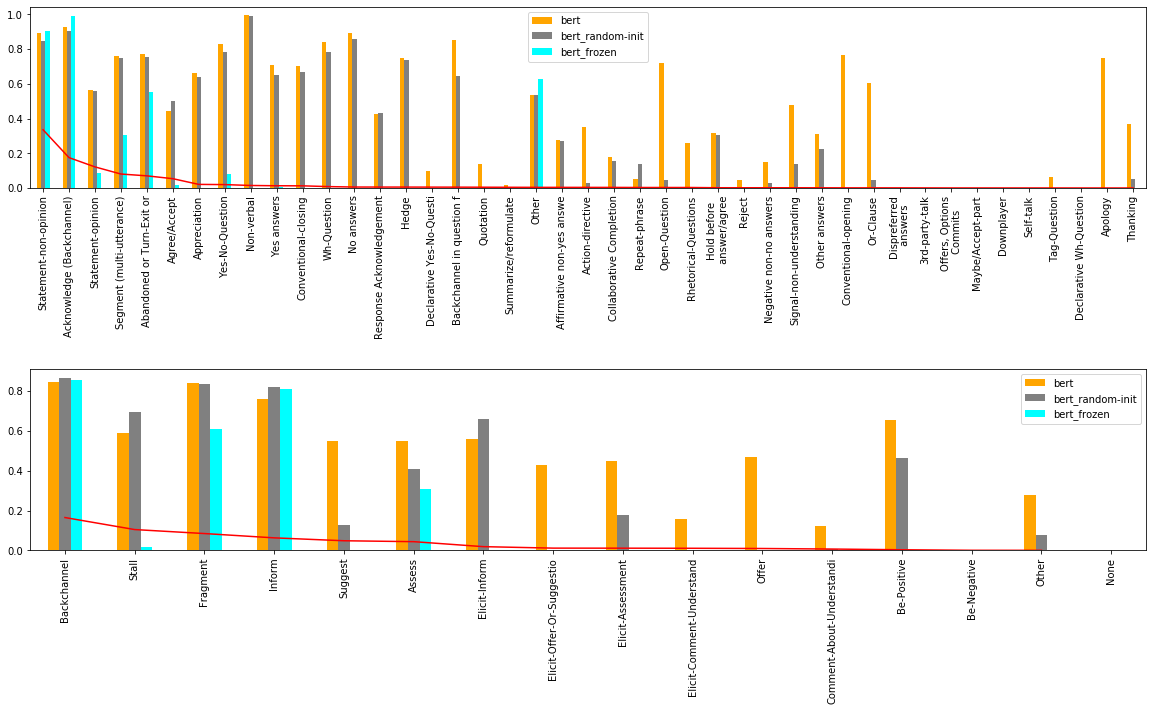

In [6]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
plt.subplots_adjust(hspace = 1)
swda_tags_display = {t:swda_tags[t][:25] for t in swda_tags}
ami_tags_display = {t:ami_tags[t][:25] for t in ami_tags}

res = pd.DataFrame([
    metrics.recall_score(dfs['da_tag'], dfs[model], swda_tags_list, average=None)
    for model in models],
    index=models, columns=swda_tags_list).rename(swda_tags_display, axis=1)
(dfs['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[0])
plot = res.T.plot(kind='bar', ax=axes[0], color=['orange', 'gray', 'cyan'])

res = pd.DataFrame([metrics.recall_score(dfa['da_tag'], dfa[model], ami_tags_list, average=None) 
              for model in models]
    , index=models, columns=ami_tags_list).rename(ami_tags_display, axis=1)
(dfa['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[1])
plot = res.T.plot(kind='bar', ax=axes[1], color=['orange', 'gray', 'cyan'])

print("Recall")

Effect of pre-trainiing, normalized by tag frequency


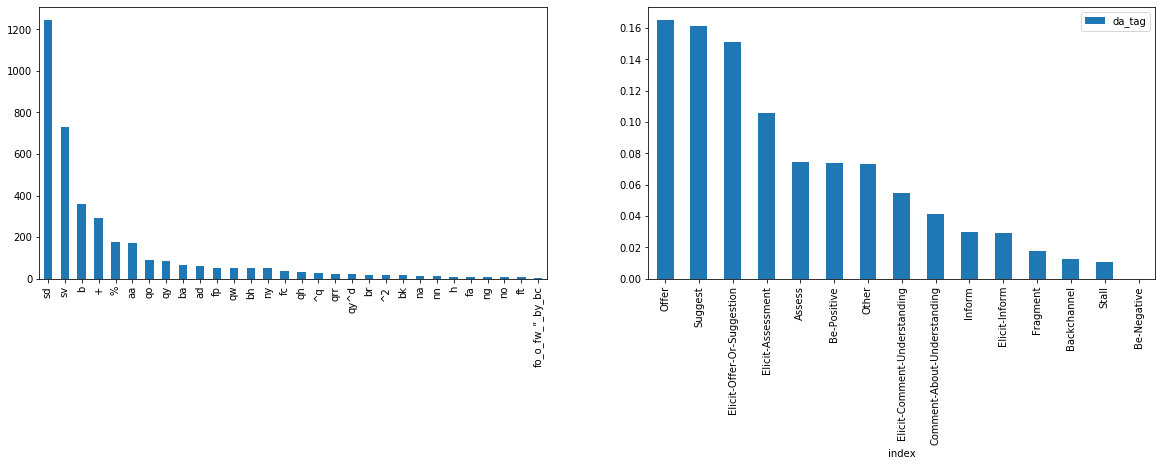

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    
tag_freq_swda = dfs['da_tag'].value_counts() / len(dfs)
tag_freq_ami  = dfa['da_tag'].value_counts() / len(dfa)

bert_beats_random = dfs[(dfs['bert']!=dfs['bert_random-init']) & (dfs['bert']==dfs['da_tag'])].da_tag.value_counts()
normalized = (bert_beats_random / bert_beats_random.sum()) / tag_freq_swda
normalized = (normalized / normalized.sum()).sort_values(ascending=False)
normalized = pd.DataFrame(normalized).reset_index()
normalized['index'] = normalized['index'].apply(swda_tags.get)
plot1 = normalized = normalized.set_index('index')
bert_beats_random.head(30).plot.bar(ax=axes[0])


bert_beats_random = dfa[(dfa['bert']!=dfa['bert_random-init']) & (dfa['bert']==dfa['da_tag'])].da_tag.value_counts()
normalized = (bert_beats_random / bert_beats_random.sum()) / tag_freq_ami
normalized = (normalized / normalized.sum()).sort_values(ascending=False)
normalized = pd.DataFrame(normalized).reset_index()
normalized['index'] = normalized['index'].apply(ami_tags.get)
normalized = normalized.set_index('index')
plot2 = normalized.plot.bar(ax=axes[1])

print("Effect of pre-trainiing, normalized by tag frequency")

In [8]:
freq = (dfs[['da_tag', 'bert', 'bert_random-init', 'bert_frozen']].apply(pd.value_counts) / len(dfs)).sort_values('da_tag', ascending=False)
freq['counts'] = dfs['da_tag'].value_counts()
freq

,da_tag,bert,bert_random-init,bert_frozen,counts
sd,0.335558,0.387599,0.373754,0.547441,14882
b,0.175062,0.201691,0.192514,0.310530,7764
sv,0.121736,0.105592,0.115310,0.029944,5399
+,0.080609,0.071545,0.080541,0.038557,3575
%,0.070169,0.064419,0.065547,0.057182,3112
aa,0.053822,0.037948,0.046404,0.007508,2387
ba,0.020902,0.016979,0.017407,0.000068,927
qy,0.019752,0.021736,0.024216,0.004126,876
x,0.014679,0.014904,0.014972,NaN,651
fc,0.013078,0.010643,0.010327,NaN,580


In [9]:
freq = (dfa[['da_tag', 'bert', 'bert_random-init', 'bert_frozen']].apply(pd.value_counts) / len(dfa)).sort_values('da_tag', ascending=False)
freq['counts'] = dfa['da_tag'].value_counts()
freq

,da_tag,bert,bert_random-init,bert_frozen,counts
ami_da_4,0.282732,0.300244,0.396382,0.454598,7314
ami_da_9,0.179327,0.174572,0.123700,0.199428,4639
ami_da_3,0.145077,0.140284,0.145270,0.130272,3753
ami_da_1,0.108044,0.142371,0.152267,0.211914,2795
ami_da_6,0.083111,0.086706,0.029997,NaN,2150
ami_da_2,0.075341,0.059415,0.079361,0.003788,1949
ami_da_5,0.032394,0.030577,0.047702,NaN,838
ami_da_12,0.019792,0.004523,0.000580,NaN,512
ami_da_16,0.019289,0.011326,0.002165,NaN,499
ami_da_11,0.018516,0.015733,0.009935,NaN,479


In [10]:
dfa['bert-correct'] = (dfa.da_tag == dfa.bert)
dfa['ri-correct'] = (dfa.da_tag == dfa['bert_random-init'])

a = dfa[['da_tag', 'bert-correct', 'ri-correct']].groupby('da_tag').mean()
a['ri-diff'] = (a['bert-correct'] - a['ri-correct'])
a = a.reset_index()
a['da_tag_desc'] = a['da_tag'].apply(ami_tags.get)
a.sort_values('ri-diff', ascending=False)

,da_tag,bert-correct,ri-correct,ri-diff,da_tag_desc
12,ami_da_7,0.470588,0.000000,0.470588,Offer
13,ami_da_8,0.429530,0.000000,0.429530,Elicit-Offer-Or-Suggestion
11,ami_da_6,0.546977,0.125116,0.421860,Suggest
1,ami_da_11,0.446764,0.177453,0.269311,Elicit-Assessment
6,ami_da_16,0.276553,0.076152,0.200401,Other
4,ami_da_14,0.655012,0.461538,0.193473,Be-Positive
3,ami_da_13,0.156250,0.000000,0.156250,Elicit-Comment-Understanding
14,ami_da_9,0.550334,0.408493,0.141841,Assess
2,ami_da_12,0.125000,0.007812,0.117188,Comment-About-Understanding
8,ami_da_3,0.838529,0.833467,0.005063,Fragment


In [11]:
dfs['bert-correct'] = (dfs.da_tag == dfs.bert)
dfs['ri-correct'] = (dfs.da_tag == dfs['bert_random-init'])

a = dfs[['da_tag', 'bert-correct', 'ri-correct']].groupby('da_tag').mean()
a['ri-diff'] = (a['bert-correct'] - a['ri-correct'])
a = a.reset_index()
a['da_tag_desc'] = a['da_tag'].apply(swda_tags.get)
a.sort_values('ri-diff', ascending=False)

,da_tag,bert-correct,ri-correct,ri-diff,da_tag_desc
22,fp,0.768116,0.000000,0.768116,Conventional-opening
19,fa,0.750000,0.000000,0.750000,Apology
32,qo,0.718519,0.044444,0.674074,Open-Question
33,qrr,0.604651,0.046512,0.558140,Or-Clause
18,br,0.477273,0.136364,0.340909,Signal-non-understanding
8,ad,0.349206,0.031746,0.317460,Action-directive
23,ft,0.368421,0.052632,0.315789,Thanking
31,qh,0.259542,0.000000,0.259542,Rhetorical-Questions
16,bh,0.855204,0.642534,0.212670,Backchannel in question form
5,^q,0.140777,0.004854,0.135922,Quotation


Interestingly, much of the increase in accuracy attributable to fine-tuning in SWDA comes from corectly identifying various kinds of questions.

- SWDA: Top three are rhetorical question (`qh`), open questions (`qo`), and action-directive (`ad`). 
  - Note that action-directive often takes the form of a question ("Why don't you go first?")
- In AMI, the top three are elicit-offer-or-suggestion, offer, and elicit-assessment. 
  - Note that offer can take the form of a question too ("Would you like me to do that?")
- quesitons likely do appear BERT's standard pre-training corpus
- the next sentence selection task *may* encourage the model to learn representations that allow it to identify the different kinds of questions, given that their answer conditions (and therefore the form of sentences felicitously answering them) are different [are there answers following questions in books/wikipedia? rehetorical questions, maybe?]
- It *can not* be the case that the increase in accuracy comes from improved representations of question *answers*, since the DAR RNN model is purely right-to-left.
- TODO: Is it the case that the questions `bert_random-init` gets wrong are miss-classified as other kids of questions (this would be quite interesting!), or are the mis-classifications evenly distributed among other dialogue acts?

## Impact of fine-tuning

Next, we consider the impact of fine-tuning (or, conversely, the failures of pre-training).

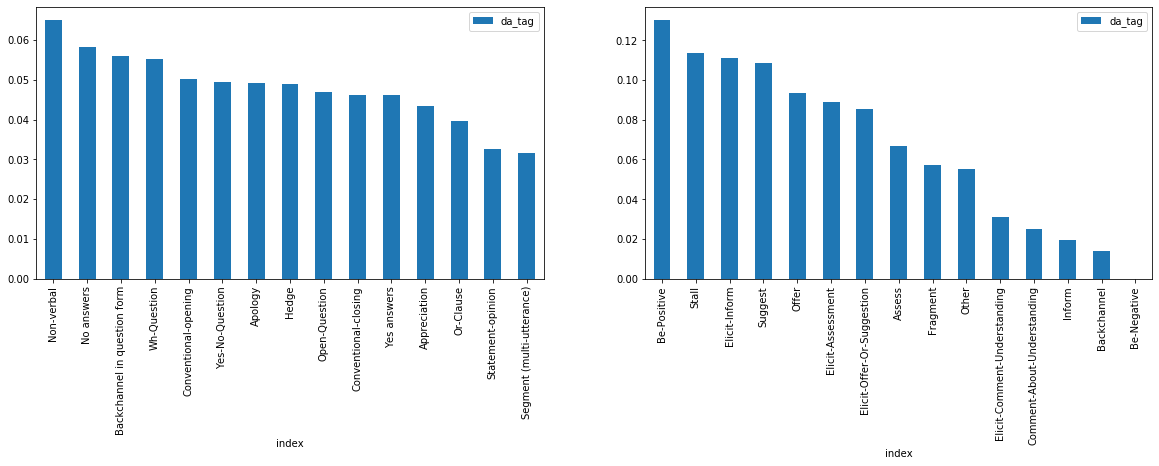

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ft_beats_frozen = dfs[(dfs['bert']!=dfs['bert_frozen']) & (dfs['bert']==dfs['da_tag'])]
ft_beats_frozen_counts = dfs[(dfs['bert']!=dfs['bert_frozen']) & (dfs['bert']==dfs['da_tag'])].da_tag.value_counts()
normalized = (ft_beats_frozen_counts / ft_beats_frozen_counts.sum()) / tag_freq_swda
normalized = (normalized / normalized.sum()).sort_values(ascending=False)
normalized = pd.DataFrame(normalized).reset_index()
normalized['index'] = normalized['index'].apply(swda_tags.get)
normalized = normalized.set_index('index')
normalized.head(15).plot.bar(ax=axes[0])


ft_beats_frozen = dfa[(dfa['bert']!=dfa['bert_frozen']) & (dfa['bert']==dfa['da_tag'])]
ft_beats_frozen_counts = dfa[(dfa['bert']!=dfa['bert_frozen']) & (dfa['bert']==dfa['da_tag'])].da_tag.value_counts()
normalized = (ft_beats_frozen_counts / ft_beats_frozen_counts.sum()) / tag_freq_ami
normalized = (normalized / normalized.sum()).sort_values(ascending=False)
normalized = pd.DataFrame(normalized).reset_index()
normalized['index'] = normalized['index'].apply(ami_tags.get)
normalized = normalized.set_index('index')
normalized.head(15).plot.bar(ax=axes[1])

In [13]:
dfa['bert-correct'] = (dfa.da_tag == dfa.bert)
dfa['fz-correct'] = (dfa.da_tag == dfa['bert_frozen'])

a = dfa[['da_tag', 'bert-correct', 'fz-correct']].groupby('da_tag').mean()
a['fz-diff'] = (a['bert-correct'] - a['fz-correct'])
a = a.reset_index()
a['da_tag_desc'] = a['da_tag'].apply(ami_tags.get)
a.sort_values('fz-diff', ascending=False)

,da_tag,bert-correct,fz-correct,fz-diff,da_tag_desc
4,ami_da_14,0.655012,0.000000,0.655012,Be-Positive
7,ami_da_2,0.587481,0.018471,0.569010,Stall
10,ami_da_5,0.558473,0.000000,0.558473,Elicit-Inform
11,ami_da_6,0.546977,0.000000,0.546977,Suggest
12,ami_da_7,0.470588,0.000000,0.470588,Offer
1,ami_da_11,0.446764,0.000000,0.446764,Elicit-Assessment
13,ami_da_8,0.429530,0.000000,0.429530,Elicit-Offer-Or-Suggestion
6,ami_da_16,0.276553,0.000000,0.276553,Other
14,ami_da_9,0.550334,0.307178,0.243156,Assess
8,ami_da_3,0.838529,0.608580,0.229949,Fragment


I don't have as strong a story to tell about these results. 

- Non-verbal (SWDA) is near the top, which makes sense because non-verbal tokens are first seen by the model in fine-tuning.
- several question types (Wh-questions, yes-no-questions in SWDA; elicit-inform, elicit assessment) are also near the top here

### Fine-tuning and laughter

Here's another chance to see how laughter is used in DAR. 
Since the `<laughter>` token doesn't appear in the original vocabulary, only the fine-tuned models can meaningfully make use of laughter in utterance representations.
So, how much lafter appears in utterances that the fine-tuned model gets correct and the frozen model gets wrong?

In [14]:
ft_beats_frozen = dfs[(dfs['bert']!=dfs['bert_frozen']) & (dfs['bert']==dfs['da_tag'])]
laughter_ft = len(ft_beats_frozen[ft_beats_frozen.utt.apply(lambda x: '<laughter>' in x)]) / len(ft_beats_frozen)
laughter_base = len(dfs[dfs.utt.apply(lambda x: '<laughter>' in x)]) / len(dfs)

print('SWDA')
print(f"%{laughter_base*100:.2f} of utterances contain laughter overall")
print(f"%{laughter_ft*100:.2f} of utterances misclassified by the frozen model, but correctly labeled by the fine-tuned model contian laughter.")

print('AMI-DA')
ft_beats_frozen = dfa[(dfa['bert']!=dfa['bert_frozen']) & (dfa['bert']==dfa['da_tag'])]
laughter_ft = len(ft_beats_frozen[ft_beats_frozen.utt.apply(lambda x: '<laughter>' in x)]) / len(ft_beats_frozen)
laughter_base = len(dfa[dfa.utt.apply(lambda x: '<laughter>' in x)]) / len(dfa)

print(f"%{laughter_base*100:.2f} of utterances contain laughter overall")
print(f"%{laughter_ft*100:.2f} of utterances misclassified by the frozen model, but correctly labeled by the fine-tuned model contian laughter.")

SWDA
%4.57 of utterances contain laughter overall
%7.30 of utterances misclassified by the frozen model, but correctly labeled by the fine-tuned model contian laughter.
AMI-DA
%8.52 of utterances contain laughter overall
%9.59 of utterances misclassified by the frozen model, but correctly labeled by the fine-tuned model contian laughter.


- For SWDA, utterances containing laugthter have an outsized impact on the improvement granted by fine-tuning.
- For AMI, it's less pronounced 
- Perhaps laughter is more helpful for DAR in SWDA than in AMI.


## How rare are the rarest words in each utterance
Comparing...
* overall in all utterances in the corpus
* among utterances that pre-trained BERT gets right
* among utterances that pre-trained BERT gets right and randomly-initialized BERT gets wrong

In [15]:
dfs['utt'] = dfs['utt'].apply(lambda x: x.lower().split())

In [16]:
words = []
for utt in dfs['utt']:
    words += utt

In [17]:
from collections import Counter
words = Counter(words)

In [18]:
words_sum = sum(words.values())
words_freq = {w: words[w] / words_sum for w in words}

In [19]:
dfs = dfs[dfs['utt'].apply(lambda x: x != [])]

In [20]:
dfs['rarest_word'] = dfs['utt'].apply(lambda x: min(map(words_freq.get, x)))

In [21]:
base_avg_freq = dfs.rarest_word.mean()
pt_avg_freq = dfs[(dfs['bert'] == dfs['da_tag']) & (dfs['bert_random-init'] != dfs['da_tag'])]['rarest_word'].mean()

In [22]:
print(f"Baseline average min frequency:           {base_avg_freq:.6f}")
print(f"Pre-training helps average min frequency: {pt_avg_freq:.6f}")
print(f"In utterances that the pre-trained model labels correctly and the randomly-initialized model labels incorrectly, "
      f"the rarest word is {base_avg_freq/pt_avg_freq:.4f} times rarer than is typcial of corpus as a whole")

Baseline average min frequency:           0.002849
Pre-training helps average min frequency: 0.001499
In utterances that the pre-trained model labels correctly and the randomly-initialized model labels incorrectly, the rarest word is 1.9008 times rarer than is typcial of corpus as a whole
